## Importations et Configuration

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

# Configuration visuelle
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Chemin des données (relatif au notebook qui est dans /data)
DATA_DIR = os.path.join(os.getcwd(), 'csv')

def clean_header(col_name):
    """Nettoie les en-têtes du type ('mid',) -> mid"""
    return re.sub(r"[()',]", "", str(col_name)).strip()

def load_clean_csv(filename):
    """Charge un CSV et nettoie ses colonnes immédiatement"""
    path = os.path.join(DATA_DIR, filename)
    if os.path.exists(path):
        df = pd.read_csv(path, low_memory=False)
        df.columns = [clean_header(c) for c in df.columns]
        return df
    else:
        print(f"⚠️ Fichier introuvable : {filename}")
        return None

## Statistiques Descriptives

In [18]:
files_to_analyze = [
    'movies.csv', 'persons.csv', 'ratings.csv', 
    'genres.csv', 'principals.csv', 'characters.csv', 
    'directors.csv', 'knownformovies.csv', 'writers.csv',
    'professions.csv', 'titles.csv'
]

dataframes = {} # Stockage pour réutilisation

for file in files_to_analyze:
    print(f"\n📁 Fichier : {file}")
    df = load_clean_csv(file)
    
    if df is not None:
        dataframes[file] = df
        
        # Dimensions
        print(f"   - Dimensions : {df.shape[0]} lignes, {df.shape[1]} colonnes")
        
        # Types et Valeurs manquantes
        missing = df.isnull().sum().sum()
        print(f"   - Total cellules vides (NaN) : {missing}")
        
        # Valeurs uniques
        print("   - Valeurs uniques (aperçu) :")
        for col in df.columns:
            print(f"     * {col}: {df[col].nunique()} uniques")


📁 Fichier : movies.csv
✅ Chargé : movies.csv avec 36859 lignes et 8 colonnes.
   - Dimensions : 36859 lignes, 8 colonnes
   - Total cellules vides (NaN) : 36899
   - Valeurs uniques (aperçu) :
     * mid: 36859 uniques
     * titleType: 1 uniques
     * primaryTitle: 34406 uniques
     * originalTitle: 35206 uniques
     * isAdult: 1 uniques
     * startYear: 111 uniques
     * endYear: 0 uniques
     * runtimeMinutes: 223 uniques

📁 Fichier : persons.csv
✅ Chargé : persons.csv avec 145847 lignes et 4 colonnes.
   - Dimensions : 145847 lignes, 4 colonnes
   - Total cellules vides (NaN) : 204137
   - Valeurs uniques (aperçu) :
     * pid: 145847 uniques
     * primaryName: 143706 uniques
     * birthYear: 286 uniques
     * deathYear: 231 uniques

📁 Fichier : ratings.csv
✅ Chargé : ratings.csv avec 36859 lignes et 3 colonnes.
   - Dimensions : 36859 lignes, 3 colonnes
   - Total cellules vides (NaN) : 0
   - Valeurs uniques (aperçu) :
     * mid: 36859 uniques
     * averageRating: 91 

## Analyses Exploratoires

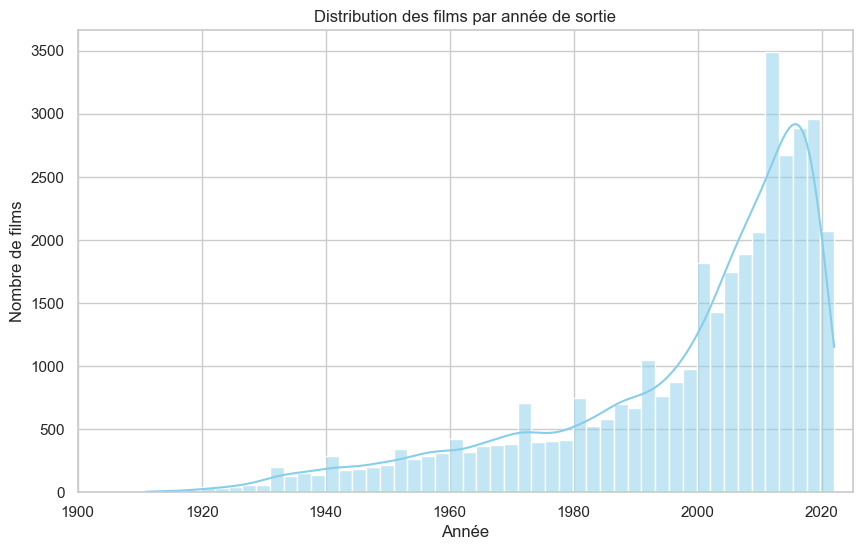

In [20]:
if 'movies.csv' in dataframes:
    df_movies = dataframes['movies.csv']
    # Conversion forcée en numérique (erreurs -> NaN)
    df_movies['startYear'] = pd.to_numeric(df_movies['startYear'], errors='coerce')
    
    plt.figure()
    sns.histplot(data=df_movies, x='startYear', bins=50, kde=True, color='skyblue')
    plt.title("Distribution des films par année de sortie")
    plt.xlabel("Année")
    plt.ylabel("Nombre de films")
    plt.xlim(1900, 2025) # On zoom sur la période pertinente
    plt.show()

C:\Users\exert\AppData\Local\Temp\ipykernel_17588\1871899615.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')


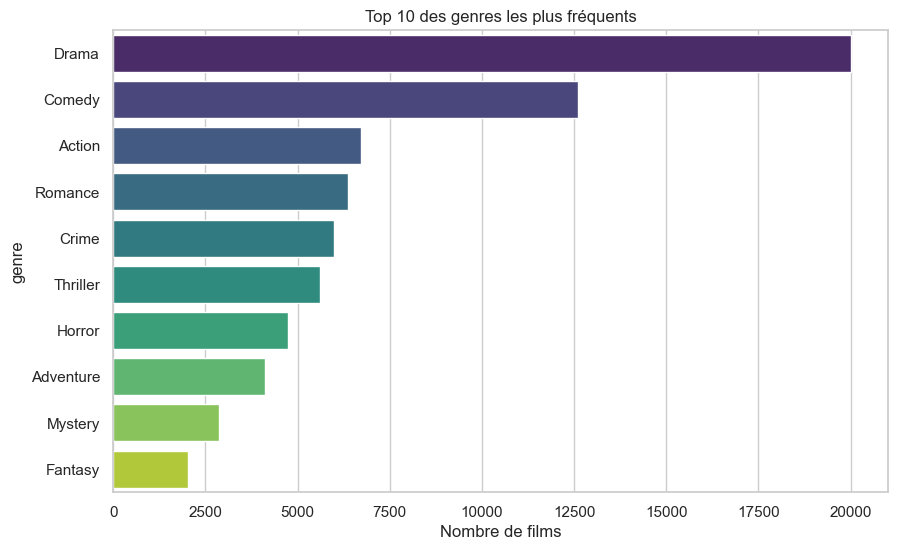

In [21]:
if 'genres.csv' in dataframes:
    df_genres = dataframes['genres.csv']
    top_genres = df_genres['genre'].value_counts().head(10)
    
    plt.figure()
    sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
    plt.title("Top 10 des genres les plus fréquents")
    plt.xlabel("Nombre de films")
    plt.show()

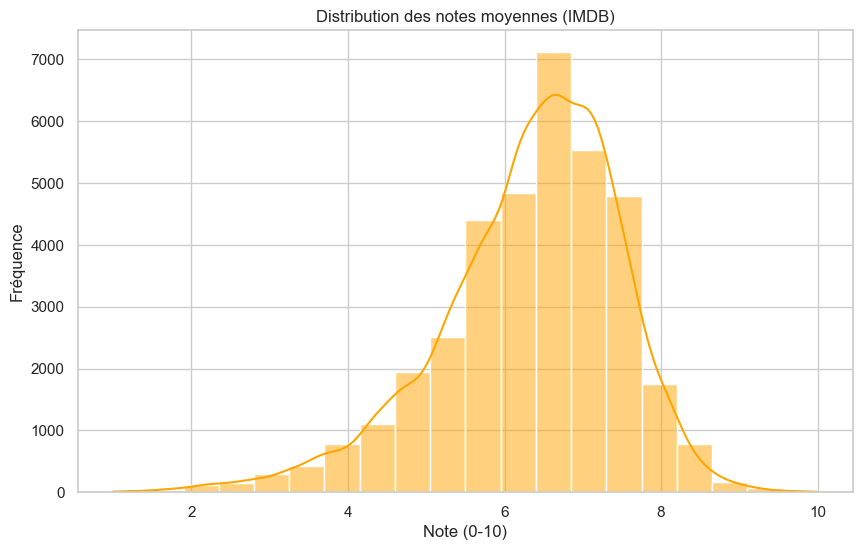

In [22]:
if 'ratings.csv' in dataframes:
    df_ratings = dataframes['ratings.csv']
    
    plt.figure()
    sns.histplot(data=df_ratings, x='averageRating', bins=20, color='orange', kde=True)
    plt.title("Distribution des notes moyennes (IMDB)")
    plt.xlabel("Note (0-10)")
    plt.ylabel("Fréquence")
    plt.show()


🎬 Nombre moyen d'acteurs par film : 4.04


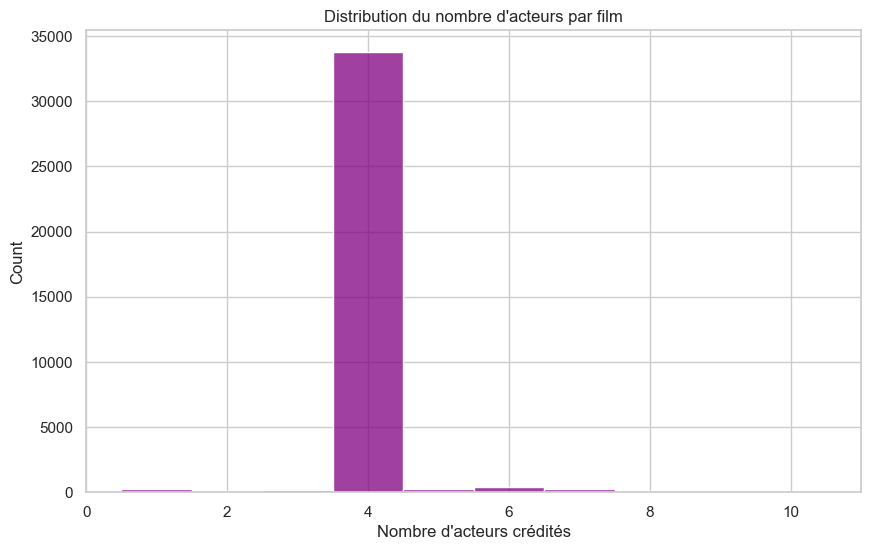

In [23]:
if 'principals.csv' in dataframes:
    df_principals = dataframes['principals.csv']
    # On filtre uniquement les acteurs/actrices
    actors = df_principals[df_principals['category'].isin(['actor', 'actress'])]
    actors_per_movie = actors.groupby('mid').size()
    
    avg_actors = actors_per_movie.mean()
    print(f"\n🎬 Nombre moyen d'acteurs par film : {avg_actors:.2f}")
    
    plt.figure()
    sns.histplot(actors_per_movie, bins=range(0, 15), discrete=True, color='purple')
    plt.title("Distribution du nombre d'acteurs par film")
    plt.xlabel("Nombre d'acteurs crédités")
    plt.show()

## Relations et Intégrité

In [24]:
if 'movies.csv' in dataframes:
    df_movies = dataframes['movies.csv']
else:
    df_movies = load_clean_csv('movies.csv')

if df_movies is not None:
    # On crée un "Set" (ensemble) des IDs valides. 
    # C'est beaucoup plus rapide que les listes pour la comparaison.
    valid_movie_ids = set(df_movies['mid'])
    print(f"🎬 Base de référence (Parent) : {len(valid_movie_ids)} films uniques dans movies.csv\n")

    # 2. Liste des tables enfants à vérifier (celles qui ont une colonne 'mid')
    # On vérifie toutes les tables qui font référence à un film
    child_files = [
        'ratings.csv', 
        'genres.csv', 
        'principals.csv', 
        'directors.csv', 
        'writers.csv', 
        'titles.csv'
    ]

    for filename in child_files:
        # On charge le fichier (ou on le récupère du dictionnaire s'il a déjà été chargé plus haut)
        if filename in dataframes:
            df_child = dataframes[filename]
        else:
            df_child = load_clean_csv(filename)
        
        # Vérification seulement si le fichier existe et contient bien une colonne 'mid'
        if df_child is not None and 'mid' in df_child.columns:
            print(f"🔹 Analyse {filename} -> movies.csv")
            
            # Récupération des IDs uniques dans la table enfant
            child_mids = set(df_child['mid'])
            
            # CALCUL DES ORPHELINS :
            # IDs présents dans l'enfant MAIS absents du parent
            orphans = child_mids - valid_movie_ids 
            
            count_orphans = len(orphans)
            
            # Affichage des résultats
            print(f"   - Films uniques référencés : {len(child_mids)}")
            
            if count_orphans > 0:
                percent = (count_orphans / len(child_mids)) * 100
                print(f"   - ⚠️ ALERTE : {count_orphans} films orphelins détectés ({percent:.4f}%)")
                print(f"   - Ces films sont dans {filename} mais PAS dans movies.csv.")
                print(f"   - Exemples d'IDs orphelins : {list(orphans)[:5]}")
            else:
                print(f"   - ✅ Intégrité parfaite : Tous les films existent dans la table mère.")
            
            print("-" * 40)
else:
    print("❌ Erreur critique : movies.csv n'a pas pu être chargé. Impossible de vérifier les relations.")

🎬 Base de référence (Parent) : 36859 films uniques dans movies.csv

🔹 Analyse ratings.csv -> movies.csv
   - Films uniques référencés : 36859
   - ✅ Intégrité parfaite : Tous les films existent dans la table mère.
----------------------------------------
🔹 Analyse genres.csv -> movies.csv
   - Films uniques référencés : 36857
   - ✅ Intégrité parfaite : Tous les films existent dans la table mère.
----------------------------------------
🔹 Analyse principals.csv -> movies.csv
   - Films uniques référencés : 36859
   - ✅ Intégrité parfaite : Tous les films existent dans la table mère.
----------------------------------------
🔹 Analyse directors.csv -> movies.csv
   - Films uniques référencés : 36851
   - ✅ Intégrité parfaite : Tous les films existent dans la table mère.
----------------------------------------
🔹 Analyse writers.csv -> movies.csv
   - Films uniques référencés : 35988
   - ✅ Intégrité parfaite : Tous les films existent dans la table mère.
----------------------------------